<a href="https://colab.research.google.com/github/HiroFumiko/SIGNATE_Practice/blob/main/Augmentation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmentationについて調べ・実装したnotebookになります
ここではpytorchにも親和性のあるAlbumentaionsを中心に用いて解説・実装します。

- そもそもAugmentationとは
- Albumentations
- TTA(Test Time Augmentationについて)
- 最適なAugmentationを見つけるアルゴリズム？

# そもそもAugmentationとは
参考：[【基本編】画像認識に使用されるData Augmentationを一挙にまとめてみた！](https://ai-scholar.tech/articles/data-augmentation/data-augmentation-image-recognition-survey)  



Data Augmentationとはデータを人工的に生成する手法のこと。  
画像を"加工"するのと、"生成"させるの二種類存在する。
細かく分けると以下の様に分類できる
1. 画像の幾何的な操作(加工系、フリップ、回転)
2. 画像の色彩空間の操作(加工系、チャネルシャッフル、)
3. カーネルフィルタなどの適用(加工系、Blur(ぼかし)、ガウシアンノイズ、やってることはCNNと変わらない)
4. 画像の一部を取り除く(加工系、クロップ)
5. 画像データの特徴ベクトルに加工(加工系)
6. 敵対的サンプルを用いる(加工系)
7. 画像を混ぜる(生成系)
8. GANによる生成画像をつかう(生成系)
9. スタイル変換の適用(生成系)

In [ ]:
## for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## for colab
!pip install albumentations==0.4.6
!pip install japanize-matplotlib

     |████████████████████████████████| 117 kB 15.0 MB/s 
     |████████████████████████████████| 948 kB 64.9 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=bce399cf7ced97bd579195cb03dc429074e87dff4ac2ed81fb99b48e94e01dd6
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 4.1 MB 12.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=b9762a99c4a5cf8ffea4fdc58828f4c032574c43a4528aad4df87cd0bc2279ed
  

In [ ]:
import sys, os
import gc
import time
from datetime import datetime
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
# import ttach as tta

import cv2
from PIL import Image

import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from matplotlib import pyplot as plt
import japanize_matplotlib
%matplotlib inline

In [ ]:
# for colab
IMAGE_PATH = '/content/drive/MyDrive/ihara/選定画像・表面の切粉（LFXV-150SWLWD45）/#1-2 [巣1] LFXV-150SW LWD45 調光180／256 F8 1ms.bmp'

# my local
# IMAGE_PATH = "D:\etc\works_aiquest\ihara\OneDrive-2021-09-26\選定画像・表面の切粉（LFXV-150SWLWD45）\#1-2 [巣1] LFXV-150SW LWD45 調光180／256 F8 1ms.bmp"


img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
img.shape

(2048, 2448, 3)

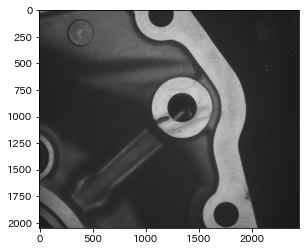

In [ ]:
plt.imshow(img)

# Albumentations
参考：[本家github](https://github.com/albumentations-team/albumentations)

かなり有名なAugmentation用の関数が豊富に用意されたライブラリです。  
torchvisionにも一部同様の関数が含まれているようですが、性能面ではこちらが優れているそうです。  
またTotensorV2というtorch tensor型に変換してくれる関数が用意されてもいるので、pytorchを使用する際にはかなり扱いやすいです。  
以下英語にはなりますが、実装されている関数とそのドキュメントです。
- [Blur](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Blur)
- [CLAHE](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.CLAHE)
- [ChannelDropout](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ChannelDropout)
- [ChannelShuffle](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ChannelShuffle)
- [ColorJitter](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ColorJitter)
- [Downscale](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Downscale)
- [Emboss](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Emboss)
- [Equalize](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Equalize)
- [FDA](https://albumentations.ai/docs/api_reference/augmentations/domain_adaptation/#albumentations.augmentations.domain_adaptation.FDA)
- [FancyPCA](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.FancyPCA)
- [FromFloat](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.FromFloat)
- [GaussNoise](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GaussNoise)
- [GaussianBlur](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GaussianBlur)
- [GlassBlur](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GlassBlur)
- [HistogramMatching](https://albumentations.ai/docs/api_reference/augmentations/domain_adaptation/#albumentations.augmentations.domain_adaptation.HistogramMatching)
- [HueSaturationValue](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.HueSaturationValue)
- [ISONoise](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ISONoise)
- [ImageCompression](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ImageCompression)
- [InvertImg](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.InvertImg)
- [MedianBlur](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.MedianBlur)
- [MotionBlur](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.MotionBlur)
- [MultiplicativeNoise](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.MultiplicativeNoise)
- [Normalize](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize)
- [PixelDistributionAdaptation](https://albumentations.ai/docs/api_reference/augmentations/domain_adaptation/#albumentations.augmentations.domain_adaptation.PixelDistributionAdaptation)
- [Posterize](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Posterize)
- [RGBShift](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RGBShift)
- [RandomBrightnessContrast](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomBrightnessContrast)
- [RandomFog](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomFog)
- [RandomGamma](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomGamma)
- [RandomRain](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomRain)
- [RandomShadow](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomShadow)
- [RandomSnow](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomSnow)
- [RandomSunFlare](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomSunFlare)
- [RandomToneCurve](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomToneCurve)
- [Sharpen](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Sharpen)
- [Solarize](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Solarize)
- [Superpixels](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Superpixels)
- [TemplateTransform](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.TemplateTransform)
- [ToFloat](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ToFloat)
- [ToGray](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ToGray)
- [ToSepia](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ToSepia)
- [Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)
- [CenterCrop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.CenterCrop)
- [CoarseDropout](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.CoarseDropout)
- [Crop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.Crop)
- [CropAndPad](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.CropAndPad)
- [CropNonEmptyMaskIfExists](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.CropNonEmptyMaskIfExists)
- [ElasticTransform](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.ElasticTransform)
- [Flip](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Flip)
- [GridDistortion](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GridDistortion)
- [GridDropout](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.GridDropout)
- [HorizontalFlip](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.HorizontalFlip)
- [Lambda](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Lambda)
- [LongestMaxSize](https://albumentations.ai/docs/api_reference/augmentations/geometric/resize/#albumentations.augmentations.geometric.resize.LongestMaxSize)
- [MaskDropout](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.MaskDropout)
- [NoOp](https://albumentations.ai/docs/api_reference/core/transforms_interface/#albumentations.core.transforms_interface.NoOp)
- [OpticalDistortion](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.OpticalDistortion)
- [PadIfNeeded](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.PadIfNeeded)
- [Perspective](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Perspective)
- [PiecewiseAffine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.PiecewiseAffine)
- [RandomCrop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.RandomCrop)
- [RandomCropNearBBox](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.RandomCropNearBBox)
- [RandomGridShuffle](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.RandomGridShuffle)
- [RandomResizedCrop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.RandomResizedCrop)
- [RandomRotate90](https://albumentations.ai/docs/api_reference/augmentations/geometric/rotate/#albumentations.augmentations.geometric.rotate.RandomRotate90)
- [RandomScale](https://albumentations.ai/docs/api_reference/augmentations/geometric/resize/#albumentations.augmentations.geometric.resize.RandomScale)
- [RandomSizedBBoxSafeCrop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.RandomSizedBBoxSafeCrop)
- [RandomSizedCrop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.RandomSizedCrop)
- [Resize](https://albumentations.ai/docs/api_reference/augmentations/geometric/resize/#albumentations.augmentations.geometric.resize.Resize)
- [Rotate](https://albumentations.ai/docs/api_reference/augmentations/geometric/rotate/#albumentations.augmentations.geometric.rotate.Rotate)
- [SafeRotate](https://albumentations.ai/docs/api_reference/augmentations/geometric/rotate/#albumentations.augmentations.geometric.rotate.SafeRotate)
- [ShiftScaleRotate](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.ShiftScaleRotate)
- [SmallestMaxSize](https://albumentations.ai/docs/api_reference/augmentations/geometric/resize/#albumentations.augmentations.geometric.resize.SmallestMaxSize)
- [Transpose](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Transpose)
- [VerticalFlip](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.VerticalFlip)

日本語だと[こちら](https://qiita.com/kurilab/items/b69e1be8d0224ae139ad)に詳しく書かれています。

## 実行テスト
今回は案件でも使えそうな関数を幾つかピックアップして実行してみます。
1. フリップ
2. 回転
3. グリッドの歪み
4. ぼかし
5. Downscale
6. その他

### 1. フリップ

Text(0.5, 1.0, '水平フリップ')

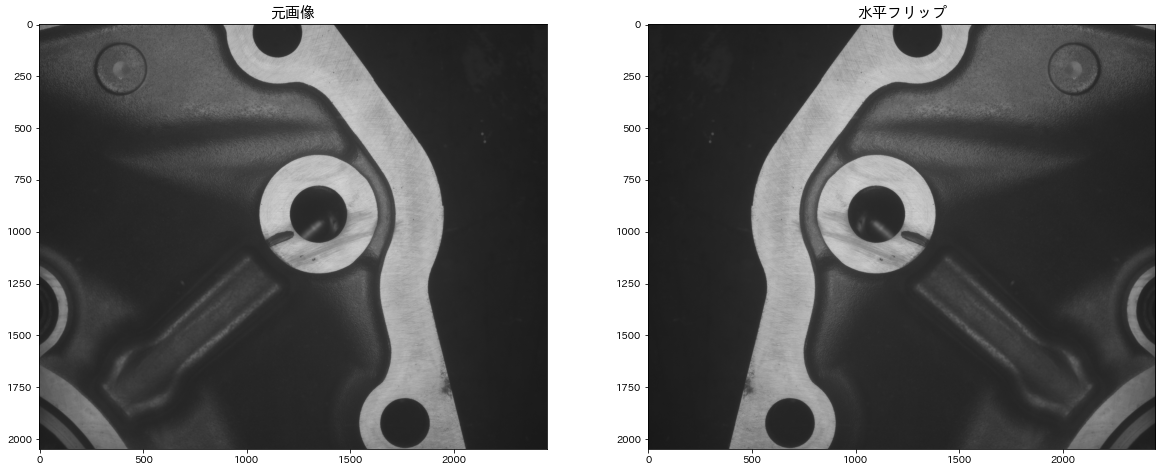

In [ ]:
# 水平フリップ

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("元画像", fontsize=15)

transforms = A.HorizontalFlip(p=1.0) # pは適用確率です。Albumentationsの関数は以下同様
plt.subplot(1, 2, 2)
plt.imshow(transforms(image=img)['image']) # or plt.imshow(transformer(**{'image': img})['image'])
plt.title("水平フリップ", fontsize=15)

Text(0.5, 1.0, '垂直フリップ')

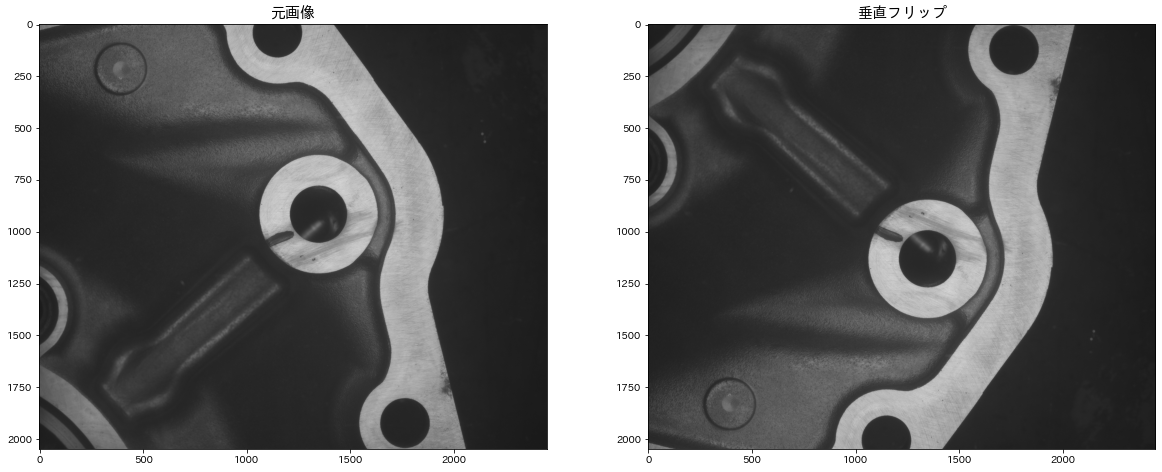

In [ ]:
# 垂直フリップ

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("元画像", fontsize=15)

transforms = A.VerticalFlip(p=1.0)
plt.subplot(1, 2, 2)
plt.imshow(transforms(image=img)['image'])
plt.title("垂直フリップ", fontsize=15)

## 2. 回転

Text(0.5, 1.0, '回転')

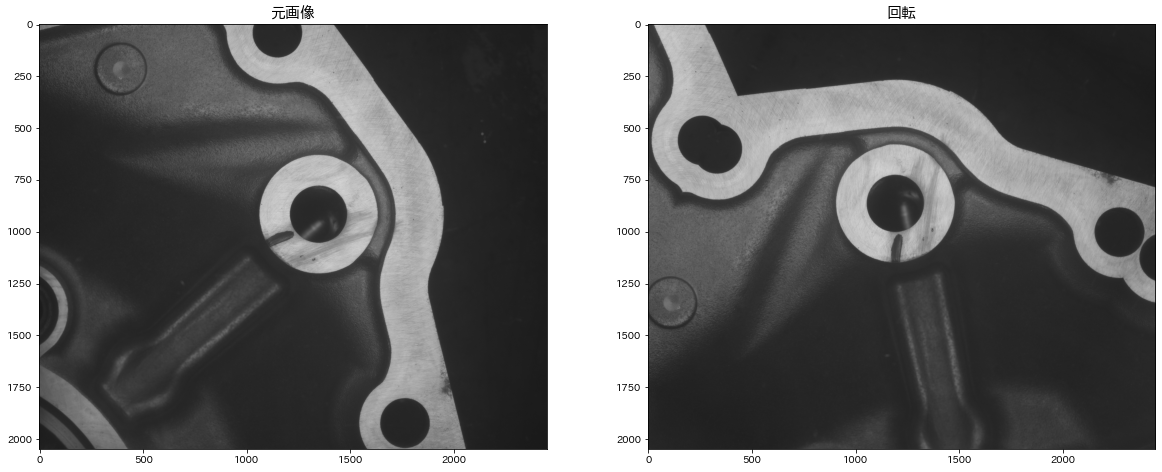

In [ ]:
# 回転

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("元画像", fontsize=15)

transforms = A.Rotate(limit=90, p=1.0) # limitで回転角度指定
plt.subplot(1, 2, 2)
plt.imshow(transforms(image=img)['image'])
plt.title("回転", fontsize=15)

Rotateは指定した回転角度を上限として、ランダムに回転します(実行するたびに結果が変わります。)

## 3. グリッドの歪み

Text(0.5, 1.0, 'グリッドの歪み')

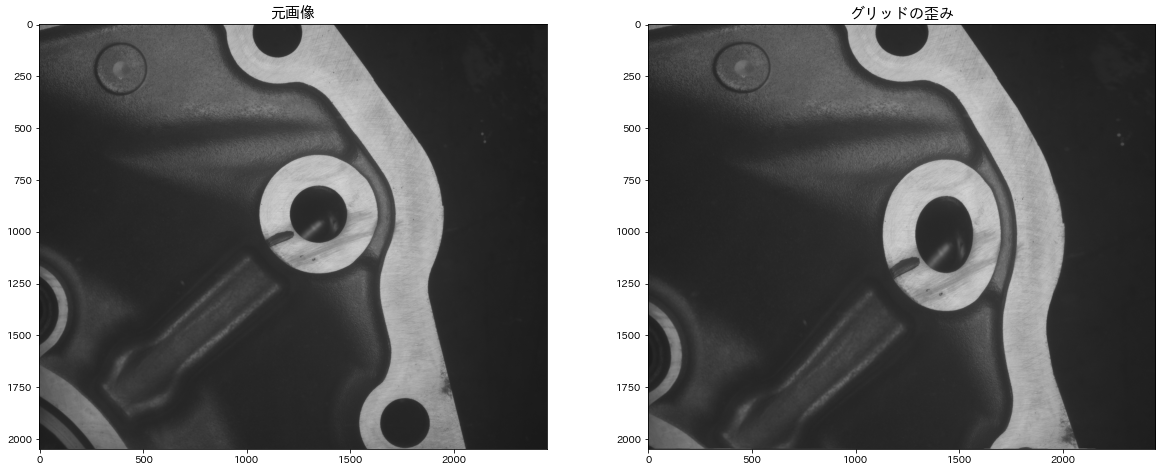

In [ ]:
# グリッドの歪み

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("元画像", fontsize=15)

transforms = A.GridDistortion(p=1.0)
plt.subplot(1, 2, 2)
plt.imshow(transforms(image=img)['image'])
plt.title("グリッドの歪み", fontsize=15)

## 4. ぼかし

Text(0.5, 1.0, 'ぼかし')

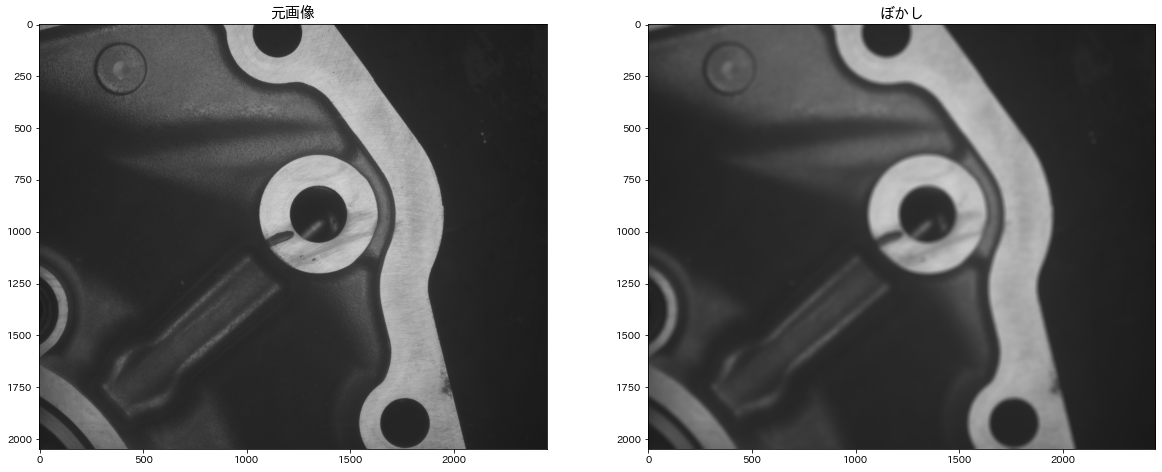

In [ ]:
# ぼかし

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("元画像", fontsize=15)

transforms = A.Blur(blur_limit=30, p=1.0)
plt.subplot(1, 2, 2)
plt.imshow(transforms(image=img)['image'])
plt.title("ぼかし", fontsize=15)

## 5. Downscale
画像の縮小を利用したノイズ付加

Text(0.5, 1.0, 'Downscale')

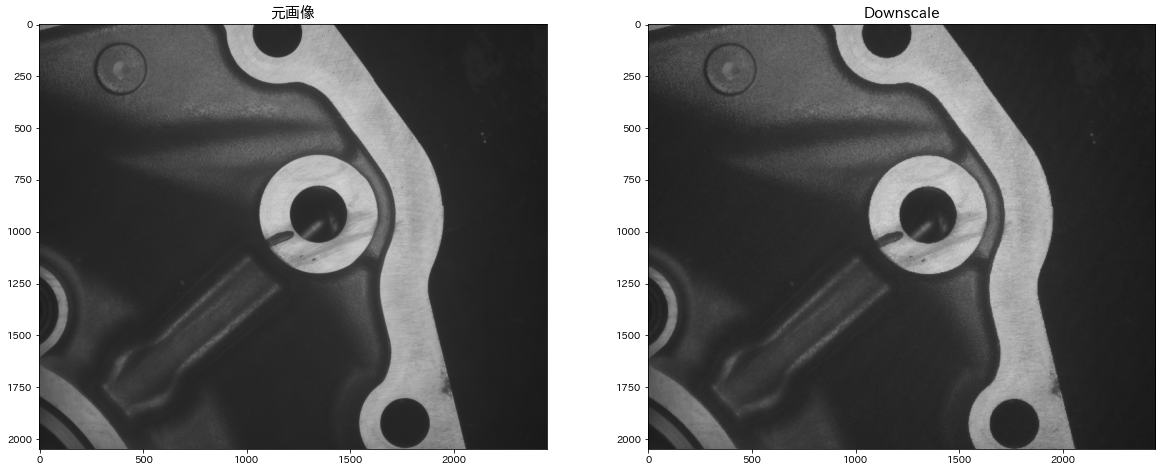

In [ ]:
# Downscale

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("元画像", fontsize=15)

transforms = A.Downscale(scale_min=0.18, p=1.0)
plt.subplot(1, 2, 2)
plt.imshow(transforms(image=img)['image'])
plt.title("Downscale", fontsize=15)

## 6. その他
- torch tensor化
- 組み合わせ
- 自作

pytorch用のテンソル化

In [ ]:
transforms = ToTensorV2(p=1.0)
tensor_img = transforms(image=img)['image']
print(type(tensor_img))

<class 'torch.Tensor'>


組み合わせ  
Composeメソッドを用います。

Text(0.5, 1.0, '1から5全部盛')

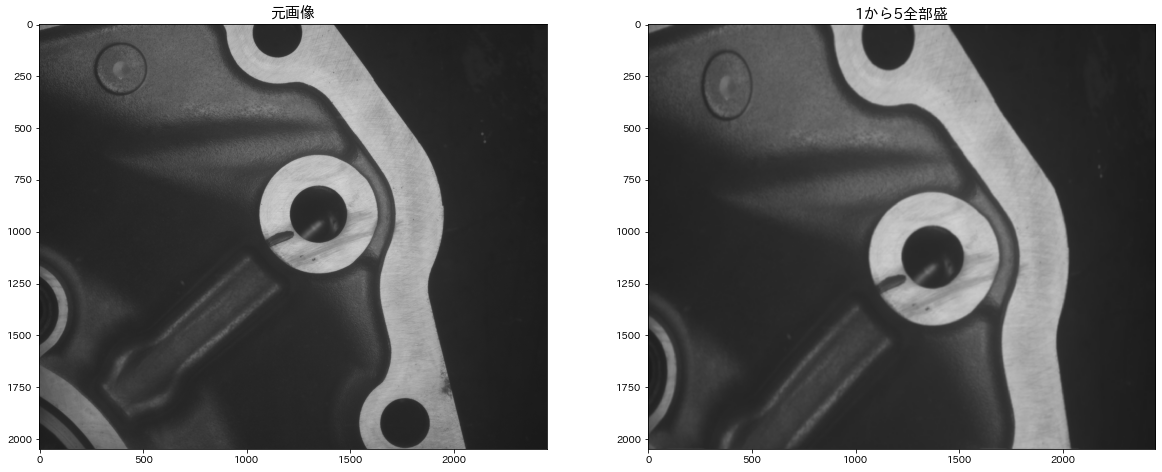

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("元画像", fontsize=15)

transforms = A.Compose([A.HorizontalFlip(p=0.5),
                         A.VerticalFlip(p=0.5),
                         A.Rotate(limit=30, p=0.5),
                         A.GridDistortion(p=1.0),
                         A.Blur(blur_limit=20, p=1.0),
                         A.Downscale(scale_min=0.18, p=1.0)])

plt.subplot(1, 2, 2)
plt.imshow(transforms(image=img)['image'])
plt.title("1から5全部盛", fontsize=15)

Compose内部に書かれた順番に適用されるので例えば
```python
transforms = A.Compose([A.HorizontalFlip(p=1.0),
                        A.VerticalFlip(p=1.0)])
```
と書くことは
```python
transforms = A.RandomRotate90(p=1.0)
```
とほぼほぼ同義です

自作  
ImageOnlyTransformを継承することで、自作のAlbumentationsモジュールを作成できます。
```python
class MyAug(ImageOnlyTransform):

    def __init__(self, 必要に応じて変数, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        必要に応じてself変数化

    def apply(self, image, **params):
        ここで処理内容
        return image
```

Albumentationsの解説は以上になりますがこのライブラリには生成系の手法はないので、生成系を実装するとなると自力で行う必要があります。  
例えばcutmix。画像の一部をくり抜いて、出来た穴に別の画像を挿入することで一枚の入力画像を生成する手法のことです。正解ラベルは画像内で占有している面積によって割合で与えられます。
これを一部実装したのが以下です(ラベルが関与するのでAlbumentationsでの実装はしていません、[参考](https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py))。

```python
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()

    # 画像の合成
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # 画像占有面積率の計算
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets # 新しいデータと新しいラベル

# 学習時
for step, batch in enumerate(data_loader):
    data, target = batch
    data = data.to('cuda', non_blocking=True)

    mix_decision = np.random.rand()
    if mix_decision < 0.5:
        data, target = cutmix(data, target, alpha=1.0)
    else:
        pass
    
    output = model(data)

    if mix_decision < 0.5:
        loss = criterion(output, target[0]) * target[2] + criterion(output, target[1]) * (1. - target[2])
    else:
        loss = criterion(output, target)
```
こんな感じで学習時にcutmixが実行されると思います。  
今更ですが、ひょっとしたらDataset内で実装したほうがいいかも？

# TTA(Test Time Augmentation)
TTAとは学習時ではなく推論時にAugmentationを実行することで、さらに精度を引き上げようという手法です。  
ただ今回の案件ではコンペとは違うので、実際にこの方法によって精度が上がったと言えるか否か、その検証自体が難しいです。(要検討)

TTAでは推論時に予測対象の画像に対して、Augmentationを行い予測するということを何度か繰り返し、その後得られた予測値を平均化して出力します。これを実装するのは結構大変ですが、[pytorch用に作られたTTAライブラリ](https://github.com/qubvel/ttach)を使うことで簡単に実装できますので、そちらを紹介します。

In [ ]:
!pip install ttach

In [ ]:
import ttach as tta

使い方
```python
# 推論にて
tta_transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
    ]
)

# 分類問題
tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)

# セグメンテーション
tta_model = tta.SegmentationTTAWrapper(model, tta_transforms, merge_mode='mean')

# 回帰系？(Keypoints modelがわからなかった single input and single outputとあったので多分回帰)
tta_model = tta.KeypointsTTAWrapper(model, tta_transforms, scaled=True)


t = time.time()
for step, batch in enumerate(data_loader):
    with torch.no_grad():
        data, target = batch
        data = data.to('cuda', non_blocking=True)

        output = tta_model(data)

        y_pred += [ output.sigmoid().detach().cpu().numpy() ] # 分類ならこんな感じ
```

ttachにあるAugmentation機能：  
- HorizontalFlip
- VerticalFlip
- Rotate90
- Scale
- Resize
- Add
- Multiply
- FiveCrops

# 最適なAugmentationを見つけるアルゴリズム？
調べていてびっくりしたのですが、最適なAugment手法を探索する手法がある様です。
- AutoAugment: 最適な幾何的変換手法を探索する手法。
- Smart Augment: 最適な画像の混ぜ方を探す手法。
- RandAugment: AutoAugmentと同じくGoogleから提案された手法。AutoAugmentに比べて計算コストが小さい